In [1]:
import bgk
import matplotlib.pyplot as plt
import bgk.run_params as rp
import os

In [2]:
# Parameters to adjust figures
case = "exact" # exact, max, exact-rev, or max-rev

nframes = 100
param = rp.ne

In [3]:
basepath = f"/mnt/lustre/IAM851/jm1667/psc-runs/case1/trials/{case}/"
# paths = ["B00.25-n256", "B00.25-n256-nicell400", "B00.25-n512-cont", "B00.25-n512-nicell25", "B00.25-n128", "B00.25-n128-nicell400", "B00.25-n128-nicell1600"]
from_ymls = [False] * 7
Bs = [.25] * 7
ress = [128] * 3 + [256] * 2 + [512] * 2
maxsteps = [500_000] * 3 + [1_000_000] * 2 + [2_000_000] * 2
nicells = [100, 400, 1600] + [100, 400] + [25, 100]
conts = [False] * 3 + [False] * 2 + [False, True]
# paths = ["B00.10-n256", "B00.10-n512", "B00.10-n1024", "B00.10-n2048"]
# Bs = [.1] * 4
# ress = [256, 512, 1024, 2048]
# maxsteps = [1000000, 1000000, 2000000, 2000000]
# from_ymls = [False, False, True, True]
# nicells = [100, 100, 100, 100]

paths = [f"B{B:05.2f}-n{res}{f'-nicell{nicell}' if nicell != 100 else ''}{'-cont' if cont else ''}" for B, res, nicell, cont in zip(Bs, ress, nicells, conts)]
print(paths)

['B00.25-n128', 'B00.25-n128-nicell400', 'B00.25-n128-nicell1600', 'B00.25-n256', 'B00.25-n256-nicell400', 'B00.25-n512-nicell25', 'B00.25-n512-cont']


In [4]:
def get_line(path, res, maxstep, nframes, param) -> tuple[list[float], list[float]]:
    run_manager = bgk.RunManager(path, maxstep)
    videoMaker = bgk.VideoMaker(nframes, run_manager)

    whole_view = bgk.Bounds3D.whole()
    videoMaker.set_variable(param)
    videoMaker.set_view_bounds(whole_view)
    
    return videoMaker.axis_t, videoMaker.get_means_at_origin(res//64)

In [5]:
# Load Data
lines: list[tuple] = []
for halfpath, res, maxstep, from_yml in zip(paths, ress, maxsteps, from_ymls):
    if from_yml:
        print(f"Loading {halfpath} from yaml...")
        data = bgk.autofigs.figdata.OriginMeans(halfpath, param.name)
        x, y = data.axis_t, data.means
        if maxstep:
            x = x[:maxstep]
            y = y[:maxstep]
    else:   
        path = basepath + halfpath
        print(f"Loading {path} from pfd...")
        # print(f"{path}, res={res}, maxstep={maxstep}")
        x, y = get_line(path, res, maxstep, nframes, param)
    lines.append((x, y))

Loading /mnt/lustre/IAM851/jm1667/psc-runs/case1/trials/exact/B00.25-n128 from pfd...
Loading /mnt/lustre/IAM851/jm1667/psc-runs/case1/trials/exact/B00.25-n128-nicell400 from pfd...
Loading /mnt/lustre/IAM851/jm1667/psc-runs/case1/trials/exact/B00.25-n128-nicell1600 from pfd...
Loading /mnt/lustre/IAM851/jm1667/psc-runs/case1/trials/exact/B00.25-n256 from pfd...
Loading /mnt/lustre/IAM851/jm1667/psc-runs/case1/trials/exact/B00.25-n256-nicell400 from pfd...
Loading /mnt/lustre/IAM851/jm1667/psc-runs/case1/trials/exact/B00.25-n512-nicell25 from pfd...
Loading /mnt/lustre/IAM851/jm1667/psc-runs/case1/trials/exact/B00.25-n512-cont from pfd...


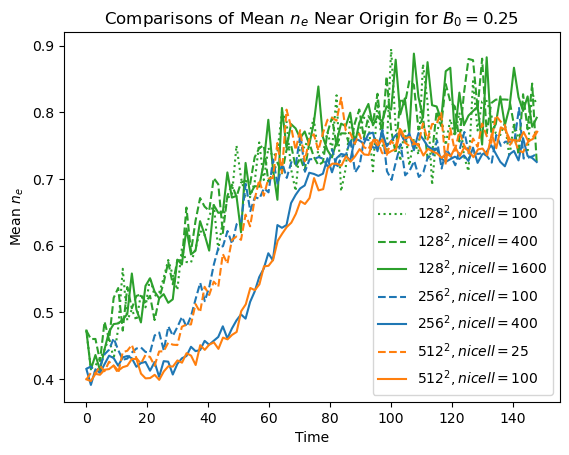

In [6]:
# Generate Figure
fig, ax = plt.subplots()

ax.set_xlabel("Time")
ax.set_ylabel(f"Mean {param.title}")
# ax.set_title(f"Comparisons of Mean {param.title} Near Origin")
ax.set_title(f"Comparisons of Mean {param.title} Near Origin for $B_0={.25}$")

for B, res, (x, y), nicell in zip(Bs, ress, lines, nicells):
    # ax.plot(x, y, label=f"$B_0={B}, n={res}$")
    
    color = {256:"tab:blue", 512:"tab:orange", 128:"tab:green"}[res]
    line = {100:"dotted", 400:"dashed", 1600:"solid"}[nicell * (res/128)**2]
    ax.plot(x, y, label=f"${res}^2, nicell={nicell}$", color=color, ls=line)
    print()


ax.legend();

In [ ]:
def get_fig_path(outdir, fig_name: str) -> str:
    return os.path.join(outdir, fig_name)

def get_fig_name() -> str:
    param_str = param.title.replace("_", "").replace("$", "")
    Bs_str = ",".join([f"B{B:05.2f}" for B in set(Bs)])
    return f"scaling-{param_str}-{case}-{Bs_str}.png"

In [ ]:
# Save Figure
outdir = f"/mnt/lustre/IAM851/jm1667/psc-scrap/figs-{case}-etc/"
os.makedirs(outdir, exist_ok=True)

fig.savefig(get_fig_path(outdir, get_fig_name()), bbox_inches="tight", pad_inches=0.01, dpi=300)